## Базовая часть:

### 1. Предобработка текстов из датасета

In [ ]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd  ./drive/MyDrive/DLS\ 2\ sem/Image\ Captioning/Flickr30k+MobileNet

/content/drive/MyDrive/DLS 2 sem/Image Captioning/Flickr30k+MobileNet


In [ ]:
!ls

flickr30k_images      FlickRMobileNet.ipynb	 results1.csv
flickr30k_images.zip  mobilenet_v2-b0353104.pth  results.csv


In [ ]:
import requests
from urllib.parse import urlencode

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/kv3BSqoXH4KewA'  # Сюда вписываете вашу ссылку

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

In [ ]:
download_url

'https://downloader.disk.yandex.ru/disk/b1bd0e3b4bf591c2534ccd6f323e77c6e3942006ccf7b29e851024fd8d131f04/60e47b2b/7MmX6uejFWFyWz_08AiVlkyymawpz_RuZiFGLMgIXP0cA4FgqtQEGfehZz1jw8Hnom9MlE4nIi-KiwYaU52gOw%3D%3D?uid=0&filename=flickr30k_images.zip&disposition=attachment&hash=j0BWn6ajvydW%2B54nPO10TtcFvE56RPVEHXzv3g25ovc4XTVoFaiyG2wDOzwxhecJq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=272481387&fsize=4381273708&hid=17f0d9f2a8ae7fa985974ac67f712e88&media_type=compressed&tknv=v2'

In [ ]:
!wget -O "data.zip" "https://downloader.disk.yandex.ru/disk/b1bd0e3b4bf591c2534ccd6f323e77c6e3942006ccf7b29e851024fd8d131f04/60e47b2b/7MmX6uejFWFyWz_08AiVlkyymawpz_RuZiFGLMgIXP0cA4FgqtQEGfehZz1jw8Hnom9MlE4nIi-KiwYaU52gOw%3D%3D?uid=0&filename=flickr30k_images.zip&disposition=attachment&hash=j0BWn6ajvydW%2B54nPO10TtcFvE56RPVEHXzv3g25ovc4XTVoFaiyG2wDOzwxhecJq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=272481387&fsize=4381273708&hid=17f0d9f2a8ae7fa985974ac67f712e88&media_type=compressed&tknv=v2"

In [ ]:
!wget https://download.pytorch.org/models/mobilenet_v2-b0353104.pth

In [ ]:
!unzip data.zip

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
import torchtext
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import os
import random
import re
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.distributions import Categorical
import numpy as np

from PIL import Image
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
df = pd.read_csv('results1.csv', delimiter='|')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df

,Unnamed: 0,image_name,comment_number,comment
0,0,0/1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1,0/1000092795.jpg,1,"Two young , White males are outside near many..."
2,2,0/1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,3,0/1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,4,0/1000092795.jpg,4,Two friends enjoy time spent together .
...,...,...,...,...
158910,158910,31/998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ov...
158911,158911,31/998845445.jpg,1,"A young man hanging over the side of a boat ,..."
158912,158912,31/998845445.jpg,2,A man is leaning off of the side of a blue an...
158913,158913,31/998845445.jpg,3,"A man riding a small boat in a harbor , with ..."


In [ ]:
vocab = torchtext.vocab.build_vocab_from_iterator([re.findall('\w+', str(cap).lower()) for cap in df[' comment'].values], min_freq=5, specials=['<pad>', '<sos>', '<eos>', ])

In [ ]:
caps = df.loc[[i + random.randint(0,4) for i in range(0,len(df),5)],['image_name', ' comment']].values

In [ ]:
train_caps, val_caps = train_test_split(caps, test_size=0.2)

In [ ]:
class FlickR30K(Dataset):
    def __init__(self, caps, vocab, max_len=20, specials=['<pad>', '<sos>', '<eos>']):
        super(FlickR30K).__init__()        
        self.vocab = vocab
        self.max_len = max_len
        self.pad = specials[0]
        self.sos = specials[1]
        self.eos = specials[2]
        self.caps = self._get_captions(caps)
    
    def _get_captions(self, captions):        
        res = []
        for i, (f, cap) in tqdm(enumerate(captions)):
            caption = re.findall('\w+', str(cap))
            сaption_idx = np.array([self.vocab[self.sos]], dtype=int)    
            for word in caption:
                if len(сaption_idx) < self.max_len - 1:
                    if word in self.vocab:
                        сaption_idx = np.append(сaption_idx, self.vocab[word])
                    else:
                        continue
                else:
                    сaption_idx = np.append(сaption_idx, self.vocab[self.eos])
                    break
            if len(сaption_idx) < self.max_len:
                сaption_idx = np.append(сaption_idx, self.vocab[self.eos])
            if len(сaption_idx) < self.max_len:
                сaption_idx = np.append(сaption_idx, np.zeros(self.max_len - len(сaption_idx),dtype=int))          
            res.append({'filename': f, 'cap_idx': сaption_idx})
        return res
    
    def _load_img(self, filename):
        input_img = Image.open('flickr30k_images/' + filename)
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
            ])
        return preprocess(input_img)
    
    def __getitem__(self, index):
        res = self.caps[index]
        img = self._load_img(res['filename'])
        cap = res['cap_idx']
        return img, torch.LongTensor(cap)

    def __len__(self):
        return len(self.caps)


In [ ]:
train_data = FlickR30K(train_caps, vocab)
val_data = FlickR30K(val_caps, vocab)
train_loader = DataLoader(train_data, batch_size=128, num_workers=2, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=128, num_workers=2, shuffle=True, drop_last=True)

In [ ]:
from torchvision.models import MobileNetV2

In [ ]:
encoder = MobileNetV2()

In [ ]:
encoder.load_state_dict(torch.load('mobilenet_v2-b0353104.pth'))

<All keys matched successfully>

In [ ]:
for param in encoder.parameters():
    param.requires_grad = False

In [ ]:
encoder.classifier = nn.Sequential(nn.Dropout(p=0.2),
                                   nn.Linear(in_features=1280, out_features=2048, bias=True))

In [ ]:
class Attention(nn.Module):
    def __init__(self, hid_dim, att_dim):
        super(Attention, self).__init__()
        self.att_dim = att_dim
        #self.feature_dim = feature_dim
        self.hid_dim = hid_dim
        self.W1 = nn.Linear(1, self.att_dim)
        self.W2 = nn.Linear(self.hid_dim, self.att_dim)
        self.V = nn.Linear(self.att_dim, 1)

    def forward(self, enc_out, dec_hidden):
        """
        enc_out [batch, enc_ch]
        dec_out [batch, dec_hidden_dim]
        """
        w1 = self.W1(enc_out.unsqueeze(2))
        w2 = self.W2(dec_hidden)
        energy = torch.tanh(w1 + w2.unsqueeze(1))
        att_weights = torch.softmax(self.V(energy).squeeze(2), dim=1)
        weighted_encoding = enc_out * att_weights
        return weighted_encoding, att_weights

In [ ]:
class MobileCaptionNet(nn.Module):
    def __init__(self, encoder, vocab_size, device, cnn_feature_size=2048,  emb_dim=200, hidden_dim=256, n_layers=2, 
                 bidirectional=False, dropout=0.2, pad_idx=0):
        super(self.__class__, self).__init__()
        self.encoder = encoder
        self.device = device
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx = pad_idx)
        self.fc_h = nn.Linear(cnn_feature_size, hidden_dim)
        self.fc_c = nn.Linear(cnn_feature_size, hidden_dim)
        self.n_layers = n_layers 
        self.rnn = nn.LSTM(cnn_feature_size + emb_dim, hidden_dim, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional)
        self.fc = nn.Linear((1 + bidirectional) * hidden_dim, vocab_size)
        self.attn = Attention(256, 512)
        
    def forward(self, images, captions_ix, hid=None, cell=None, TF=1):
        image_vectors = self.encoder(images)
        if isinstance(hid, torch.Tensor):
            h = hid
        else:
            h = self.fc_h(image_vectors.repeat(self.n_layers,1,1))
        if isinstance(cell, torch.Tensor):
            c = cell            
        else:
            c = self.fc_c(image_vectors.repeat(self.n_layers,1,1)) 
        embedded = self.embedding(captions_ix).permute(1,0,2)
        sent_len = embedded.shape[0]
        batch_size = embedded.shape[1]        
        logits = torch.zeros(sent_len, batch_size, self.vocab_size).to(self.device)
        input = embedded[0].unsqueeze(0)
        if sent_len == 1:
            w_enc, _ = self.attn(image_vectors, h[-1])
            output, (h, c) = self.rnn(torch.cat((input, w_enc.unsqueeze(0)),dim=2), (h, c))
            logit = self.fc(output)
            return logit, h, c
        for t in range(1, sent_len):
            w_enc, _ = self.attn(image_vectors, h[-1])
            output, (h, c) = self.rnn(torch.cat((input, w_enc.unsqueeze(0)),dim=2), (h, c))
            logit = self.fc(output)
            logits[t] = logit
            teacher_force = random.random() < TF
            top1 = self.embedding(logit.argmax(-1))
            input = embedded[t].unsqueeze(0) if teacher_force else top1            
        return logits 

In [ ]:
def compute_loss(network, images, captions_ix, TF=1):
    logits = network(images, captions_ix, TF)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    loss = criterion(logits[1:].permute(0,2,1),captions_ix[:,1:].permute(1,0))  
    return loss

In [ ]:
network = MobileCaptionNet(encoder, len(vocab),device).to(device)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

In [ ]:
def train(model, iterator, optimizer, clip, TF, train_history=None, valid_history=None):
    model.train()    
    epoch_loss = 0
    history = []
    for i, (images, caps) in enumerate(iterator):        
        optimizer.zero_grad()        
        loss = compute_loss(model, images.to(device), caps.to(device), TF)
        loss.backward()        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        optimizer.step()        
        epoch_loss += loss.item()        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()            
            plt.show()        
    return epoch_loss / len(iterator)

def evaluate(model, iterator):
    model.eval()    
    epoch_loss = 0    
    history = []    
    with torch.no_grad():    
        for i, (images, caps) in enumerate(iterator):
            loss = compute_loss(model, images.to(device), caps.to(device), TF=0)           
            epoch_loss += loss.item()        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

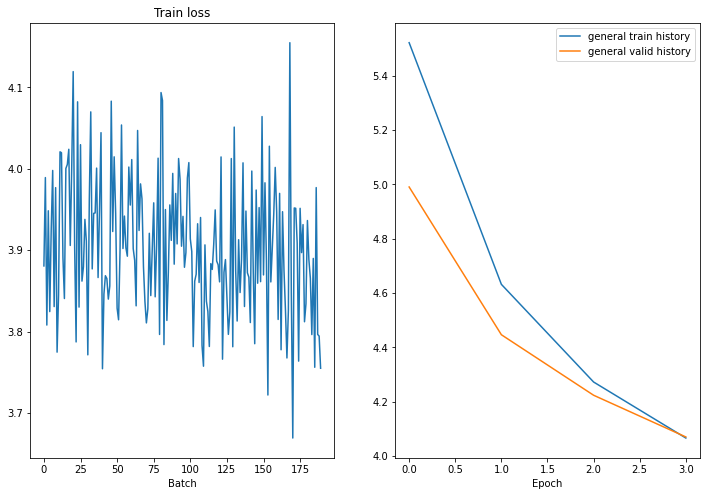

Epoch: 05 | Time: 2m 56s
	Train Loss: 3.903 | Train PPL:  49.552
	 Val. Loss: 3.969 |  Val. PPL:  52.909


In [ ]:
#TF train
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 5
CLIP = 1
TF=1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    if epoch == 14:
        optimizer.param_groups[0]['lr'] /= 10      
    start_time = time.time()
    
    train_loss = train(network, train_loader, optimizer, CLIP, TF, train_history, valid_history)
    valid_loss = evaluate(network, val_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
           
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(network.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

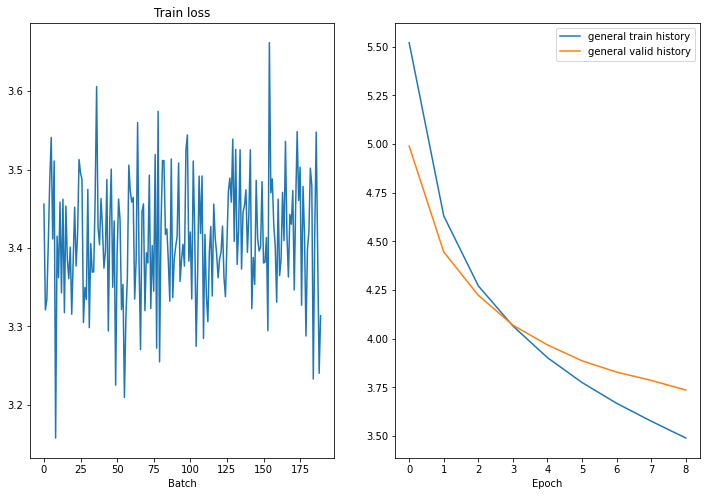

Epoch: 05 | Time: 2m 53s
	Train Loss: 3.413 | Train PPL:  30.358
	 Val. Loss: 3.711 |  Val. PPL:  40.880


In [ ]:
for epoch in range(N_EPOCHS):
        
    start_time = time.time()
    
    train_loss = train(network, train_loader, optimizer, CLIP, TF, train_history, valid_history)
    valid_loss = evaluate(network, val_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
           
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(network.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
@torch.no_grad()
def generate_caption(image, model, vocabulary, t=1,
                     sample=True, max_len=100, mode='distrib'):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    model.eval()
    vocab = vocabulary.get_itos() 
    input = torch.ones(1,1,dtype=torch.int).to(device)
    result = []
    h,c = None, None
    img = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32).unsqueeze(0).to(device)
    if mode == 'distrib':
        for _ in range(max_len):
            logit, h, c = model(img, input, h, c, TF=0)
            probs = torch.softmax(logit[0,0]/t, dim=-1)            
            distribution = Categorical(probs)
            sampled = distribution.sample()
            result.append(vocab[sampled.item()])
            if result[-1] == '<eos>':
                break 
            input = torch.tensor([[sampled.item()]]).to(device)
    if mode == 'greedy':
        for _ in range(max_len):
            logit, h, c = model(img, input, h, c, TF=0)
            input = logit.argmax(-1)
            result.append(vocab[input.item()])
            if result[-1] == '<eos>':
                break                               
    return result

--2021-07-06 12:58:03--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-07-06 12:58:03--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.007s  

2021-07-06 12:58:03 (7.82 MB/s) - ‘img.jpg’ saved [54731

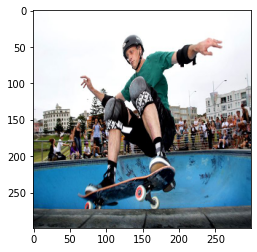

In [ ]:
from matplotlib import pyplot as plt
#from scipy.misc import imresize
import cv2
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img =  cv2.resize(src=img, dsize=(299, 299), interpolation=cv2.INTER_CUBIC).astype('float32') / 255
#img = imresize(img, (299, 299)).astype('float32') / 255.
plt.imshow(img)

In [ ]:
print(' '.join(generate_caption(img, network, vocab, mode='greedy')[:-1]).capitalize())

Man in a blue shirt is standing in front of a large building


In [ ]:
for _ in range(5):
    print(' '.join(generate_caption(img, network, vocab, t=1)[:-1]).capitalize())

Man wearing a dress and light latex eyes holds a in his something
Child rests down a track with worship merchandise on the shore
Woman and a white dog is jumping a group of trampoline in the woods
Man with cold cap slides through front of a neighborhood with a rodeo saxophone typing by
Drink is pulling a play counter in front of a motorcycle the green dolls


--2021-07-06 12:58:14--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-07-06 12:58:14--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K   555KB/s    in 0.2s    

2021-07-06 12:58:15 (555 KB/s) - ‘img.jpg’ saved [106870/106870]



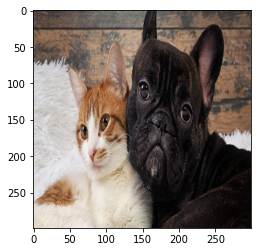

In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img =  cv2.resize(src=img, dsize=(299, 299), interpolation=cv2.INTER_CUBIC).astype('float32') / 255

plt.imshow(img)
plt.show()

In [ ]:
print(' '.join(generate_caption(img, network, vocab, mode='greedy')[:-1]).capitalize())

Dog is standing in a chair with a large dog
